In [4]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # For analysing and manipulating data
import yfinance as yf
import matplotlib.pyplot as plt # For visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler #to normalize the price data 

In [5]:
import torch
from torch import nn, optim
import torch.nn as nn
import torch.nn.functional as F
from jcopdl.callback import Callback, set_config 



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
# Selecting the dataset's start & end date 
import datetime
stocks = ["ANTM.JK"]
today=datetime.date.today().strftime('%Y-%m-%d')
start_date=pd.to_datetime('2005-9-30')
end_date=pd.to_datetime(today)
data_stock = yf.download(stocks, start=start_date, end=end_date)
df = pd.DataFrame(data_stock)
df = pd.concat([data_stock['Close']],axis=1) # Creating new dataframe containing only the 'Close' column 
df.columns = ['ANTM_Close']
df

[*********************100%***********************]  1 of 1 completed


,ANTM_Close
Date,
2005-09-29,432.588074
2005-09-30,457.787384
2005-10-03,470.387024
2005-10-04,474.586914
2005-10-05,482.986694
...,...
2022-08-04,1970.000000
2022-08-05,2020.000000
2022-08-08,2060.000000


In [7]:
df_Transf = pd.Series(MinMaxScaler().fit_transform(df['ANTM_Close'].values.reshape(-1,1)).flatten())
df_Transf = pd.array(df_Transf)
df.index=pd.to_datetime(df.index)
df['ANTM_Close']

Date
2005-09-29     432.588074
2005-09-30     457.787384
2005-10-03     470.387024
2005-10-04     474.586914
2005-10-05     482.986694
                 ...     
2022-08-04    1970.000000
2022-08-05    2020.000000
2022-08-08    2060.000000
2022-08-09    2180.000000
2022-08-10    2120.000000
Name: ANTM_Close, Length: 4176, dtype: float64

In [39]:
df_Transf

<PandasArray>
[ 0.03681223000984864, 0.043183925047665925, 0.046369768708359835,
 0.047431719167400965, 0.049555620085483226, 0.045307825965748186,
 0.046369768708359835, 0.045307825965748186, 0.045307825965748186,
 0.046369768708359835,
 ...
   0.4331354100035298,  0.42175707173723737,  0.45336356692138285,
   0.4318711501961639,  0.42554985115933486,  0.42554985115933486,
    0.438192449232993,  0.44830652769191964,  0.47864876306869925,
   0.4634776453803094]
Length: 4176, dtype: float64

<AxesSubplot:xlabel='Date'>

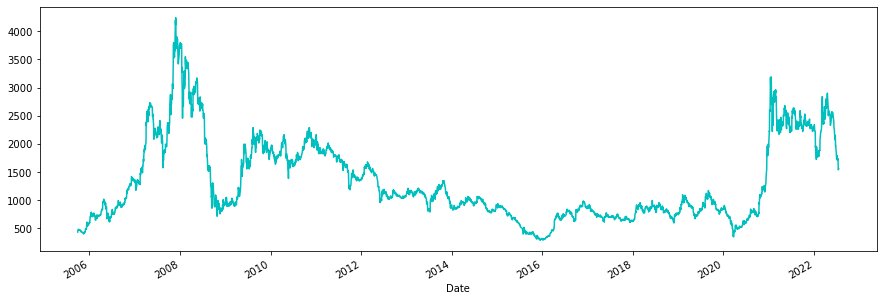

In [39]:
#df_Transf.plot(figsize=(15,5),color='b')
df.ANTM_Close.plot(figsize=(15,5),color='c')

In [8]:
#Dataset Splitting
y_train, y_test = train_test_split(df, test_size=0.2,shuffle=False)
y_train.shape, y_test.shape

((3340, 1), (836, 1))

In [9]:
#Dataset & Dataloader
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset



In [10]:
seq_len=14
bs = 32

train_set=TimeSeriesDataset(y_train, "ANTM_Close",seq_len)
trainloader=DataLoader(train_set, batch_size=bs)

test_set=TimeSeriesDataset(y_test, "ANTM_Close",seq_len)
testloader=DataLoader(test_set, batch_size=bs)

(N, S, F): (238, 14, 1)
Note: last 7 data excluded

(N, S, F): (59, 14, 1)
Note: last 9 data excluded



In [13]:
#Arsitektur dan Komfigurasi
class LSTM (nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, output_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def foward (self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden                   
          

In [34]:
config = set_config ({
    "input_size":train_set.n_feature,
    "seq_len":train_set.n_seq,
    "output_size":1,
    "hidden_size":64,
    "num_layers":3,
    "epoch":25,
    "dropout":0
})

In [42]:
#Training
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost/len(dataset)
    return cost

In [36]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test_cost", test_set, trainloader, model, criterion, optimizer, device)
        
    #Logging
    callback.log(train_cost, test_cost)

    #cekpoint
    callback.save_checkpoit()

    #Runtime Ploting
    callback.cost_runtime_plotting()

    #Early Stoping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

NameError: name 'model' is not defined